In [1]:
%pip install polars-lts-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 1.2 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [6]:
def pfbeta(labels, predictions, beta=1):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

def get_part_metrics(df: pl.DataFrame, threshold=0.3) -> dict:
    df = df.with_columns((df["preds"] > threshold).alias("preds_bin"))
    metrics = {}
    # binary metrics using the threshold
    metrics["accuracy"] = accuracy_score(df["labels"].to_numpy(), df["preds_bin"].to_numpy())
    metrics["precision"] = precision_score(df["labels"].to_numpy(), df["preds_bin"].to_numpy())
    metrics["recall"] = recall_score(df["labels"].to_numpy(), df["preds_bin"].to_numpy())
    metrics["f1"] = f1_score(df["labels"].to_numpy(), df["preds_bin"].to_numpy())
    # probabilistic F1 (doesn't depend on the threshold)
    metrics["pf1"] = pfbeta(df["labels"].to_numpy(), df["preds"].to_numpy())
    # ROC AUC
    metrics["roc_auc"] = roc_auc_score(df["labels"].to_numpy(), df["preds"].to_numpy())
    return metrics


def get_all_metrics(df: pl.DataFrame, threshold=0.3) -> pd.DataFrame:
    groups = [list(range(5)), [0, 1], [0, 4], [0, 2], [0, 3]]
    group_names = ["all", "StableDiffusion", "Midjourney", "Dalle2", "Dalle3"]
    all_metrics = []
    for i, g in enumerate(groups):
        subset = df.filter(pl.col("domains").is_in(g))
        metrics = get_part_metrics(subset, threshold=threshold)
        metrics["group"] = group_names[i]
        all_metrics.append(metrics)
    
    return pd.DataFrame(all_metrics)

In [ ]:
# Load the data from the output files
df1 = pl.read_csv('/Users/fionachow/Downloads/outputs/preds-image-classifier-1.csv')
df14 = pl.read_csv('/Users/fionachow/Downloads/outputs/preds-image-classifier-14.csv')
df142 = pl.read_csv('/Users/fionachow/Downloads/outputs/preds-image-classifier-142.csv')
df1423 = pl.read_csv('/Users/fionachow/Downloads/outputs/preds-image-classifier-1423.csv')

metrics_df1 = get_all_metrics(df1, threshold=0.5)
metrics_df14 = get_all_metrics(df14, threshold=0.5)
metrics_df142 = get_all_metrics(df142, threshold=0.5)
metrics_df1423 = get_all_metrics(df1423, threshold=0.5)

In [14]:
metrics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   accuracy   5 non-null      float64
 1   precision  5 non-null      float64
 2   recall     5 non-null      float64
 3   f1         5 non-null      float64
 4   pf1        5 non-null      float64
 5   roc_auc    5 non-null      float64
 6   group      5 non-null      object 
dtypes: float64(6), object(1)
memory usage: 408.0+ bytes


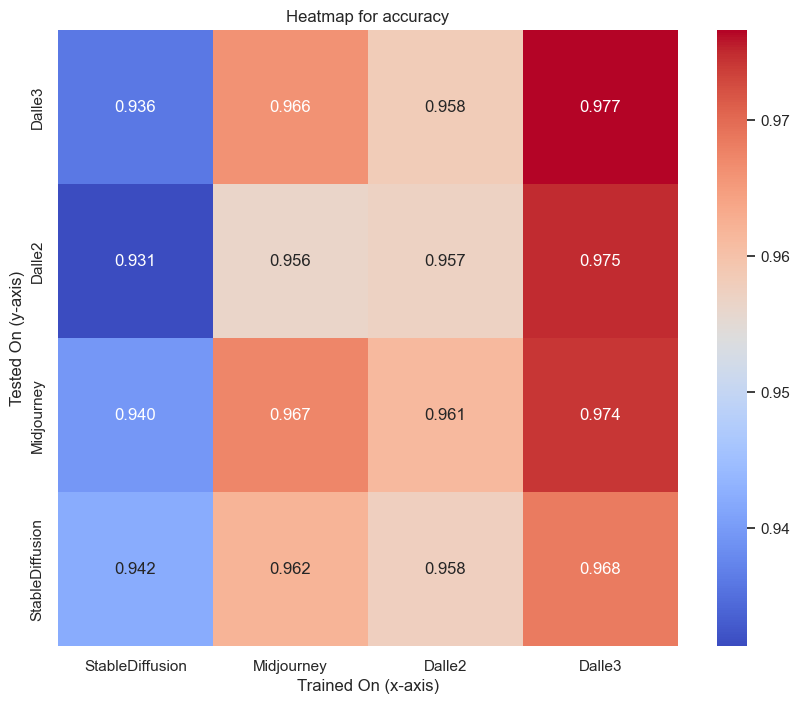

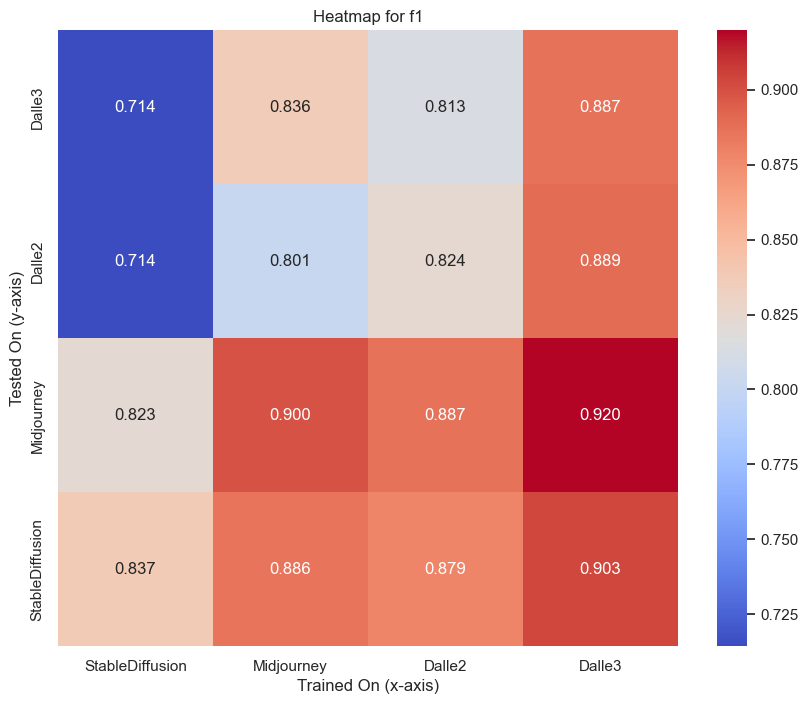

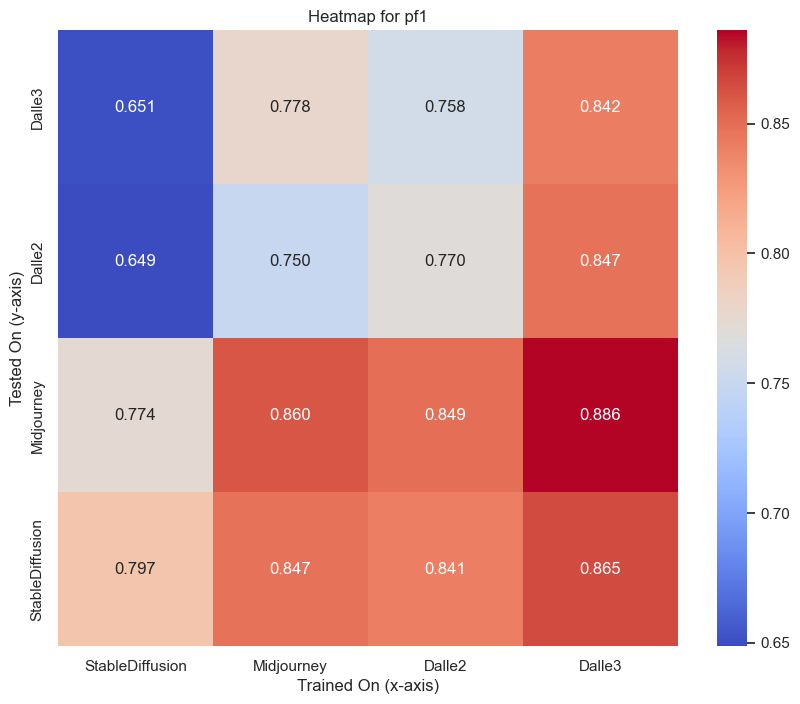

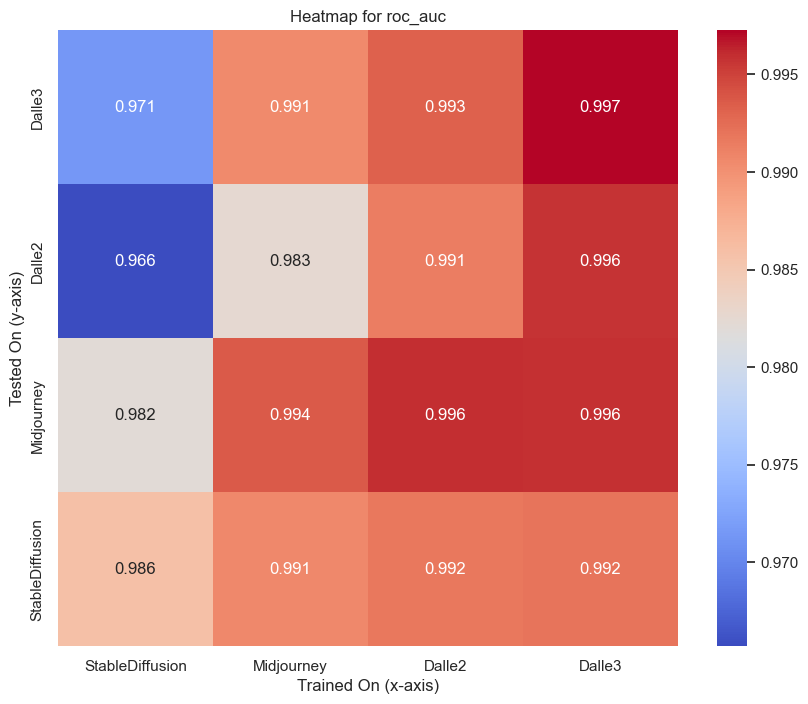

In [29]:
sns.set()

models = ['StableDiffusion', 'Midjourney', 'Dalle2', 'Dalle3']
metrics = ['accuracy', 'f1', 'pf1', 'roc_auc']

file_map = {
    ('StableDiffusion',): metrics_df1,
    ('StableDiffusion', 'Midjourney'): metrics_df14,
    ('StableDiffusion', 'Midjourney', 'Dalle2'): metrics_df142,
    ('StableDiffusion', 'Midjourney', 'Dalle2', 'Dalle3'): metrics_df1423,
}

def create_heatmap_data(metric):
    data = pd.DataFrame(index=models[::-1], columns=models)
    for i, model_x in enumerate(models):
        for j, model_y in enumerate(models[::-1]):
            
            if i == 0:
                relevant_df = metrics_df1
            elif i == 1:
                relevant_df = metrics_df14
            elif i == 2:
                relevant_df = metrics_df142
            else:
                relevant_df = metrics_df1423

            # Debugging: print the DataFrame being used and the model_y
            #print(f"Using DataFrame for {models[:i+1]}, model_y: {model_y}")

            # Extract the metric value
            if model_y in relevant_df['group'].values:
                metric_value = relevant_df[relevant_df['group'] == model_y][metric].values[0]
                # Debugging: print the extracted metric value
                #print(f"Metric value for {model_y}: {metric_value}")
            else:
                metric_value = float('nan')  # Handle non-existent cases
                # Debugging: print a message for non-existent cases
                #print(f"No data for combination: {model_x}, {model_y}")

            data.at[model_y, model_x] = metric_value
    
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Debugging: print the final DataFrame
    # print(f"Final Data for metric {metric}:")
    # print(data)
    # print(data.dtypes)
    return data

for metric in metrics:
    plt.figure(figsize=(10, 8))
    sns.heatmap(create_heatmap_data(metric), annot=True, cmap='coolwarm', fmt='.3f')
    plt.title(f"Heatmap for {metric}")
    plt.xlabel("Trained On (x-axis)")
    plt.ylabel("Tested On (y-axis)")
    plt.show()